# DePaul Capstone
## RQ2 Analysis - Inpatient Readmission
Griffin Reichmuth

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold,\
                                    cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, \
                            confusion_matrix, roc_curve,precision_recall_curve,\
                            roc_auc_score, auc, make_scorer
from sklearn.metrics import make_scorer, precision_score, \
                            recall_score, f1_score, \
                            average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset
from textwrap import wrap
from google.colab import files
from google.cloud import storage, bigquery
import json
import pickle

In [2]:
grid_search_params = 1
make_predictions = 0
save_to_csv = 0
data_w_preds_in_bucket = 0

### Query Data

In [ ]:
df = pd.read_csv('data_claim_diagnosis_census.csv')

Query is running:   0%|          |

Downloading:   0%|          |

### Exploratory Data Analysis

In [5]:
df.head(1)

,bene_id,clm_id,benefit_yr_key,claim_file,nch_clm_type_cat,claim_processing_type,is_inpatient_claim,is_outpatient_claim,is_durable_medical_equipment_claim,is_hospice_claim,...,health_insurance_civilian_18_64_unemployed_no_insurance_pct,health_insurance_civilian_18_64_unemployed_pct,health_insurance_civilian_18_64_unemployed_private_pct,health_insurance_civilian_18_64_unemployed_public_pct,health_insurance_civilian_18_64_unemployed_with_insurance_pct,health_insurance_civilian_population_pct,health_insurance_civilian_under_18_no_insurance_pct,health_insurance_civilian_under_18_pct,next_clm_admsn_dt,readmit_30
0,-10000010287944,-10000931481188,b'\xe1\x01Ev\x1d\xd6\xe1$\xcd\xbbU\x08\xc6{g\x...,Inpatient,Inpatient,Part A only ICR,True,False,False,False,...,19.7,1450,30.0,51.0,80.3,57466,3.0,19745,2019-10-19,0


In [6]:
df.describe().transpose()[:25]

,count,mean,std,min,25%,50%,75%,max
bene_id,20919.0,-10000010270649.568359,9633.356635,-10000010288010.0,-10000010278482.0,-10000010271058.0,-10000010262265.5,-10000010254618.0
clm_id,20919.0,-10000930747724.267578,425902.519636,-10000931486024.0,-10000931121724.5,-10000930761924.0,-10000930377919.0,-10000930037831.0
claim_start_year,20919.0,2019.100387,2.311558,2015.0,2017.0,2019.0,2021.0,2023.0
claim_start_month,20919.0,6.522109,3.457067,1.0,4.0,7.0,10.0,12.0
claim_end_year,20919.0,2019.103781,2.312577,2015.0,2017.0,2019.0,2021.0,2023.0
claim_duration_in_days,20919.0,1.05244,3.195344,0.0,0.0,0.0,1.0,104.0
clm_pmt_amt,20919.0,6746.955346,21928.262262,62.44,168.71,1070.72,3777.265,598716.31
clm_pmt_per_rank_tot,20919.0,0.417683,0.352175,0.0,0.064,0.3337,0.8694,0.9242
clm_pmt_per_rank_file,20919.0,0.498397,0.286771,0.0,0.25055,0.5,0.7482,0.9998
org_npi_num,20919.0,1508650597.993308,291761249.668262,1003027921.0,1265576946.0,1538101852.0,1760420103.0,1992970891.0


In [7]:
df.describe().transpose()[25:50]

,count,mean,std,min,25%,50%,75%,max
clm_pps_cptl_drg_wt_num,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bene_tot_coinsrnc_days_cnt,20919.0,0.002295,0.305469,0.0,0.0,0.0,0.0,44.0
clm_non_utlztn_days_cnt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_blood_pnts_frnshd_qty,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_drg_outlier_aprvd_pmt_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_bene_ptb_coinsrnc_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_bene_partb_ddctbl_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clm_op_prvdr_pmt_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_carr_clm_sbmtd_chrg_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nch_clm_prvdr_pmt_amt,20919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.describe().transpose()[50:75]

,count,mean,std,min,25%,50%,75%,max
commute_other_means_pct,17769.0,-10017444.303979,81106833.366923,-666666666.0,0.7,1.4,2.3,78.9
commute_public_transport_pct,17769.0,-10017441.530362,81106833.709511,-666666666.0,0.2,1.0,3.8,100.0
commute_walked_pct,17769.0,-10017443.241404,81106833.498168,-666666666.0,0.7,1.4,2.8,100.0
commute_worked_at_home_pct,17769.0,-10017438.686533,81106834.060769,-666666666.0,3.4,5.9,9.7,100.0
commute_workers_total_pct,17769.0,12268.862964,9232.648735,0.0,4404.0,11188.0,18068.0,62444.0
employment_children_6_17_parents_labor_force_pct,17769.0,-20560082.013434,115259699.617026,-666666666.0,65.5,72.5,78.1,100.0
employment_children_6_17_pct,17769.0,3854.987337,3265.561363,0.0,1373.0,3093.0,5570.0,39556.0
employment_children_under_6_parents_labor_force_pct,17769.0,-22998791.224678,121673576.385383,-666666666.0,58.0,66.9,74.5,100.0
employment_children_under_6_pct,17769.0,1870.585627,1647.928204,0.0,586.0,1514.0,2703.0,25981.0
employment_civilian_labor_force_pct,17769.0,13250.699645,9999.821161,0.0,4696.0,12053.0,19299.0,65669.0


In [9]:
df.describe().transpose()[75:100]

,count,mean,std,min,25%,50%,75%,max
health_insurance_civilian_18_64_labor_force_pct,17769.0,12258.338286,9408.351782,0.0,4274.0,11028.0,17932.0,62788.0
health_insurance_civilian_18_64_not_labor_force_no_insurance_pct,17769.0,-13431617.812539,93672336.793414,-666666666.0,6.5,11.9,19.2,100.0
health_insurance_civilian_18_64_not_labor_force_pct,17769.0,3357.614216,2749.896911,0.0,1308.0,2908.0,4547.0,25631.0
health_insurance_civilian_18_64_not_labor_force_private_pct,17769.0,-13431577.196511,93672342.617657,-666666666.0,38.8,53.4,72.1,100.0
health_insurance_civilian_18_64_not_labor_force_public_pct,17769.0,-13431595.864196,93672339.940755,-666666666.0,21.7,36.5,49.3,100.0
health_insurance_civilian_18_64_not_labor_force_with_insurance_pct,17769.0,-13431547.911751,93672346.817017,-666666666.0,80.0,87.6,93.2,100.0
health_insurance_civilian_18_64_pct,17769.0,15615.952502,11877.717909,0.0,5620.0,14337.0,22325.0,79102.0
health_insurance_civilian_18_64_unemployed_no_insurance_pct,17769.0,-19884790.306596,113410159.794066,-666666666.0,13.5,25.6,39.3,100.0
health_insurance_civilian_18_64_unemployed_pct,17769.0,707.025775,703.114781,0.0,190.0,528.0,964.0,9172.0
health_insurance_civilian_18_64_unemployed_private_pct,17769.0,-19884774.197377,113410162.618743,-666666666.0,26.5,42.0,61.6,100.0


In [10]:
df.describe().transpose()[100:125]

,count,mean,std,min,25%,50%,75%,max


In [11]:
list(df.columns)

['bene_id',
 'clm_id',
 'benefit_yr_key',
 'claim_file',
 'nch_clm_type_cat',
 'claim_processing_type',
 'is_inpatient_claim',
 'is_outpatient_claim',
 'is_durable_medical_equipment_claim',
 'is_hospice_claim',
 'is_home_health_agency_claim',
 'is_skilled_nursing_facility_claim',
 'clm_from_dt',
 'clm_thru_dt',
 'claim_start_year',
 'claim_start_month',
 'benefit_mth_key',
 'claim_end_year',
 'claim_duration_in_days',
 'clm_pmt_amt',
 'clm_pmt_per_rank_tot',
 'clm_pmt_per_rank_file',
 'carr_clm_prvdr_asgnmt_bool',
 'prncpal_dgns_cd',
 'org_npi_num',
 'clm_fac_type_cat',
 'claim_is_in_hospital',
 'clm_srvc_clsfctn_type_cat',
 'clm_freq_cat',
 'clm_tot_chrg_amt',
 'fst_dgns_e_cd',
 'claim_has_external_cause',
 'clm_hha_tot_visit_cnt',
 'clm_admsn_dt',
 'clm_utlztn_day_cnt',
 'nch_bene_dschrg_dt',
 'clm_hospc_start_dt_id',
 'admission_is_emergency',
 'admission_is_urgent',
 'admission_is_elective',
 'clm_src_ip_admsn_cat',
 'clm_pass_thru_per_diem_amt',
 'nch_bene_ip_ddctbl_amt',
 'nch_be

In [12]:
# review data types
data_types = pd.DataFrame(df.dtypes).reset_index().sort_values(by=['index'])

vars_data_types = {}
for i in range(len(data_types)):
  type_is = str(data_types[0][i])
  var_is = data_types['index'][i]
  vars_data_types.setdefault(type_is, []).append(var_is)

In [13]:
vars_data_types.keys()

dict_keys(['Int64', 'object', 'boolean', 'float64'])

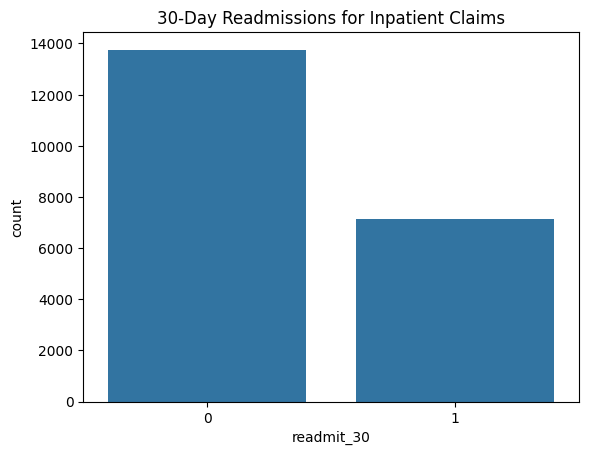

In [14]:
# visualize readmission length output label
sns.countplot(x ='readmit_30', \
              data = df).set(title = '30-Day Readmissions for Inpatient Claims')

plt.show()

In [15]:
len(df[df['readmit_30'] == 1])

7157

In [16]:
len(df[df['readmit_30'] == 0])

13762

### Data Cleaning + Feature Engineering

In [17]:
sentinel_values = [-999999999,-888888888,-666666666]
sel_columns = [col for col in df.columns if \
               df[col].dtype in ['Int64', 'float64']]
df[sel_columns] = df[sel_columns].replace(sentinel_values,np.nan)
pct_columns = [col for col in df.columns if 'pct' in col]


cols_to_drop = [col for col in pct_columns if df[col].max() > 100]
df = df.drop(columns=cols_to_drop)

In [18]:
df['age_at_end_ref_yr'] = df.benefit_yr - df['bene_birth_dt'].apply(lambda x: x.year)

In [19]:
# bin age
# left bin edge is exclusvie; right bin edge is inclusive

category = pd.cut(df.age_at_end_ref_yr, bins=[0,39,59,69,74,79,120],
                  labels=['0-39','40-59','60-69','70-74','75-79','80-max'])

df.insert(6,'age_group',category)
df['age_group'].value_counts()

,count
age_group,
80-max,5054
60-69,4119
40-59,3789
70-74,2740
0-39,2704
75-79,2495


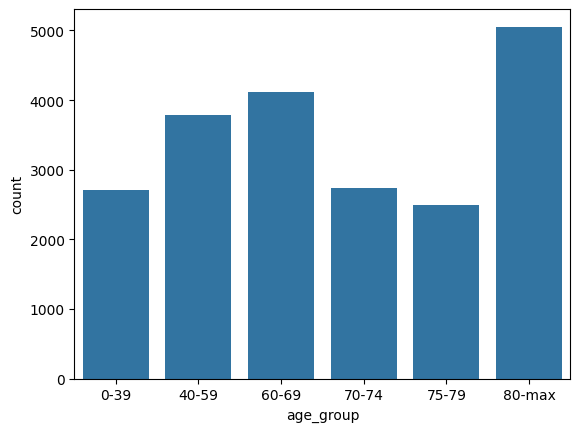

In [20]:
# plot age groups
sns.countplot(x ='age_group', data = df)

plt.show()

In [21]:
# create list of supplemental diagnosis column names
supp_dgns_cols = []
for i in range(1, 26):
  supp_dgns_cols.append(f'ICD_DGNS_{i}')
supp_dgns_cols.append('ICD_DGNS_99')

In [22]:
chron_con =  ['ami_icds', 'ad_icds', 'anemia_icds', 'asthma_icds', 'afib_flutter_icds', 'bph_icds', 'breast_ca_icds',
         'colorectal_ca_icds','endometrial_ca_icds', 'lung_ca_icds', 'prostate_ca_icds', 'urologic_ca_icds',
          'cataract_icds', 'ckd_icds', 'copd_icds', 'dep_bipolar_others_icds', 'dm_icds', 'glaucoma_icds',
          'hf_non_ischemic_hd_icds','hip_pelvic_fx_icds', 'hlp_icds', 'htn_icds', 'ht_icds', 'ihd_icds', 'nad_icds',
           'or_with_without_pathological_fx_icds', 'pd_and_sp_icds','pneumonia_all_cause_icds', 'ra_oa_icds',
            'stroke_tia_icds']

In [23]:
# create dummy variables for each chronic condition based on the
# supplemental diagnosis columns
for con in chron_con:
    df[con] = \
    df[supp_dgns_cols].apply(lambda row: con in row.values, axis=1).astype(int)

In [26]:
# Generate Dummies

# define boolean variables to keep
cols_bool = ['admission_is_emergency', 'admission_is_urgent',
             'admission_is_elective', 'beneficiary_is_male',
             'beneficiary_is_female', 'beneficiary_is_white',
              'beneficiary_is_not_white', 'beneficiary_is_black',
             'beneficiary_is_asian_or_pi', 'beneficiary_is_hispanic',
             'beneficiary_is_indigenous', 'beneficiary_is_other_race']

# define categorical variables to keep
cols_cat = ['age_group','prncpal_dgns_cd','admtg_chronic','principal_chronic',
            'ICD_DGNS_1','ICD_DGNS_2','ICD_DGNS_3','ICD_DGNS_4','ICD_DGNS_5',
            'ICD_DGNS_6','ICD_DGNS_7','ICD_DGNS_8','ICD_DGNS_9','ICD_DGNS_10',
            'ICD_DGNS_11','ICD_DGNS_12','ICD_DGNS_13','ICD_DGNS_14',
            'ICD_DGNS_15','ICD_DGNS_16','ICD_DGNS_17','ICD_DGNS_18',
            'ICD_DGNS_19','ICD_DGNS_20','ICD_DGNS_21','ICD_DGNS_22',
            'ICD_DGNS_23','ICD_DGNS_24','ICD_DGNS_25','ICD_DGNS_99']

# define numeric variables to keep
cols_num = ['claim_duration_in_days','commute_mean_travel_time_min',
            'class_of_worker_government_pct',
            'class_of_worker_private_wage_pct',
            'class_of_worker_self_employed_pct',
            'class_of_worker_unpaid_family_pct',
            'commute_carpooled_pct',
            'commute_drove_alone_pct',
            'commute_other_means_pct',
            'commute_public_transport_pct',
            'commute_walked_pct',
            'commute_worked_at_home_pct',
            'employment_children_6_17_parents_labor_force_pct',
            'employment_children_under_6_parents_labor_force_pct',
            'employment_females_16_over_civilian_labor_force_pct',
            'employment_females_16_over_labor_force_pct',
            'employment_population_16_over_armed_forces_pct',
            'employment_population_16_over_employed_pct',
            'employment_population_16_over_not_labor_force_pct',
            'employment_population_16_over_unemployed_pct',
            'employment_unemployment_rate_pct',
            'health_insurance_civilian_18_64_employed_no_insurance_pct',
            'health_insurance_civilian_18_64_employed_private_pct',
            'health_insurance_civilian_18_64_employed_public_pct',
            'health_insurance_civilian_18_64_employed_with_insurance_pct',
            'health_insurance_civilian_18_64_not_labor_force_no_insurance_pct',
            'health_insurance_civilian_18_64_not_labor_force_private_pct',
            'health_insurance_civilian_18_64_not_labor_force_public_pct',
            'health_insurance_civilian_18_64_not_labor_force_with_insurance_pct',
            'health_insurance_civilian_18_64_unemployed_no_insurance_pct',
            'health_insurance_civilian_18_64_unemployed_private_pct',
            'health_insurance_civilian_18_64_unemployed_public_pct',
            'health_insurance_civilian_18_64_unemployed_with_insurance_pct',
            'health_insurance_civilian_under_18_no_insurance_pct']

dashboard_reqs = ['bene_id', 'claim_end_year']


In [27]:
# create dummy variables
df_cat = pd.get_dummies(df[cols_cat])

# combine dummies with dataframe
df_combined = pd.concat([df,df_cat], axis=1)

# save names of dummy vars
df_all_cat = list(df_cat.columns)

# combine predictors and output variables
df_30 = df_combined[df_all_cat + cols_bool + chron_con + cols_num + \
                    ['readmit_30'] + dashboard_reqs]

df_30.head()

,age_group_0-39,age_group_40-59,age_group_60-69,age_group_70-74,age_group_75-79,age_group_80-max,prncpal_dgns_cd_A4152,prncpal_dgns_cd_A419,prncpal_dgns_cd_B002,prncpal_dgns_cd_B085,...,health_insurance_civilian_18_64_not_labor_force_with_insurance_pct,health_insurance_civilian_18_64_unemployed_no_insurance_pct,health_insurance_civilian_18_64_unemployed_private_pct,health_insurance_civilian_18_64_unemployed_public_pct,health_insurance_civilian_18_64_unemployed_with_insurance_pct,health_insurance_civilian_under_18_no_insurance_pct,zip_five,readmit_30,bene_id,claim_end_year
0,False,False,False,False,False,True,False,False,False,False,...,85.6,19.7,30.0,51.0,80.3,3.0,92571,0,-10000010287944,2019
1,False,False,True,False,False,False,False,False,False,False,...,98.0,0.0,76.5,23.5,100.0,0.0,92014,0,-10000010287904,2022
2,False,False,False,False,False,True,False,False,False,False,...,88.3,21.9,41.0,42.8,78.1,2.9,91040,0,-10000010287875,2018
3,False,False,True,False,False,False,False,False,False,False,...,79.4,17.1,39.2,54.0,82.9,5.1,91411,0,-10000010287866,2020
4,False,False,True,False,False,False,False,False,False,False,...,88.3,0.9,52.3,50.5,99.1,4.0,90670,1,-10000010287637,2020


In [28]:
# check for missing values in categorical variables
null_check = pd.DataFrame(df_30.isnull().sum().reset_index())
null_check[null_check[0] != 0]

,index,0
711,age_group,18
713,admtg_chronic,19736
714,principal_chronic,18776
749,commute_mean_travel_time_min,20919
750,class_of_worker_government_pct,3429
751,class_of_worker_private_wage_pct,3429
752,class_of_worker_self_employed_pct,3429
753,class_of_worker_unpaid_family_pct,3429
754,commute_carpooled_pct,3417
755,commute_drove_alone_pct,3417


In [114]:
# every value is null, so remove column
df_30 = df_30.drop(columns=['commute_mean_travel_time_min'])

In [55]:
df_30 = df_30.dropna()

In [ ]:
# copy with dashboard reqs
df_to_table = df_30.copy()

# remove dashboard reqs from df_30
df_30 = df_30.drop(columns=dashboard_reqs)

## Feature Selection

In [ ]:
# split features from label
X = df_30.iloc[:, :-1]
y = df_30.iloc[:, -1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [ ]:
# Train random forest and get feature importances
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_

In [ ]:
# Display feature importances
feature_importances = pd.Series(importances, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)[:50]
print(top_features)

ckd_icds                                                              0.042970
ihd_icds                                                              0.024521
dm_icds                                                               0.021099
health_insurance_civilian_18_64_not_labor_force_private_pct           0.019974
health_insurance_civilian_18_64_not_labor_force_public_pct            0.019140
prncpal_dgns_cd_Z733                                                  0.016020
health_insurance_civilian_18_64_employed_private_pct                  0.015998
health_insurance_civilian_18_64_unemployed_private_pct                0.015884
health_insurance_civilian_18_64_employed_public_pct                   0.014728
employment_population_16_over_employed_pct                            0.014473
health_insurance_civilian_18_64_unemployed_public_pct                 0.014043
employment_females_16_over_labor_force_pct                            0.014012
commute_worked_at_home_pct                          

In [ ]:
# keep features with importance >= 0.01 (total 30 features)
top_features = pd.DataFrame(top_features)
top_feats = top_features[top_features[0] >= 0.01]
selected_feats = list(pd.DataFrame(top_feats).index)
df_30_sel = df_30[selected_feats + ['readmit_30']]

# using df_30, df_to_table, that has the dashboard requirement
# features and subset by selected_feats and add the label
df_to_table = df_to_table[selected_feats + dashboard_reqs + ['readmit_30']]
df_30_sel.head()

,ckd_icds,ihd_icds,dm_icds,health_insurance_civilian_18_64_not_labor_force_private_pct,health_insurance_civilian_18_64_not_labor_force_public_pct,prncpal_dgns_cd_Z733,health_insurance_civilian_18_64_employed_private_pct,health_insurance_civilian_18_64_unemployed_private_pct,health_insurance_civilian_18_64_employed_public_pct,employment_population_16_over_employed_pct,...,health_insurance_civilian_18_64_not_labor_force_no_insurance_pct,employment_unemployment_rate_pct,employment_females_16_over_civilian_labor_force_pct,commute_public_transport_pct,commute_walked_pct,health_insurance_civilian_under_18_no_insurance_pct,commute_other_means_pct,age_group_80-max,age_group_0-39,readmit_30
0,0,1,1,37.5,50.3,False,64.6,30.0,23.7,59.2,...,14.4,6.1,54.3,0.7,0.7,3.0,1.0,True,False,0
1,0,0,1,84.3,13.7,False,97.2,76.5,5.1,55.0,...,2.0,4.4,51.4,0.3,0.2,0.0,1.3,False,False,0
2,0,0,0,56.7,36.6,False,86.5,41.0,9.2,58.7,...,11.7,4.2,58.5,1.3,1.0,2.9,0.2,True,False,0
3,0,0,0,29.5,51.5,False,64.2,39.2,20.3,69.9,...,20.6,6.4,68.9,7.7,2.1,5.1,2.7,False,False,0
4,1,0,1,53.0,39.9,False,84.9,52.3,11.1,59.7,...,11.7,3.3,55.5,1.1,0.8,4.0,2.2,False,False,1


## Modeling

In [ ]:
# split features from label
X_sel = df_30_sel.iloc[:, :-1]
y_sel = df_30_sel.iloc[:, -1]

X_tr, X_test_sel, y_tr, y_test_sel = \
                  train_test_split(X_sel, y_sel, test_size=0.4, random_state=1)


### Logistic Regression

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_tr, y_tr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Define the cross-validation strategy (10-fold)
cv_lr = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': make_scorer(average_precision_score)
}

# Perform cross-validation and get the results
cv_results_lr = cross_validate(model_lr, X_sel, y_sel, cv=cv_lr,
                               scoring=scoring, n_jobs=-1)

# Calculate mean values for each metric
mean_accuracy_lr = np.mean(cv_results_lr['test_accuracy'])
mean_precision_lr = np.mean(cv_results_lr['test_precision'])
mean_recall_lr = np.mean(cv_results_lr['test_recall'])
mean_f1_lr = np.mean(cv_results_lr['test_f1'])
mean_roc_auc_lr = np.mean(cv_results_lr['test_roc_auc'])
mean_avg_precision_lr = np.mean(cv_results_lr['test_average_precision'])

# Print the results
print(f"Mean Accuracy: {mean_accuracy_lr:.4f}")
print(f"Mean Precision: {mean_precision_lr:.4f}")
print(f"Mean Recall: {mean_recall_lr:.4f}")
print(f"Mean F1-Score: {mean_f1_lr:.4f}")
print(f"Mean AUROC: {mean_roc_auc_lr:.4f}")
print(f"Mean Precision-Recall AUC: {mean_avg_precision_lr:.4f}")

Mean Accuracy: 0.7596
Mean Precision: 0.6871
Mean Recall: 0.5617
Mean F1-Score: 0.6179
Mean AUROC: 0.7130
Mean Precision-Recall AUC: 0.5377


In [ ]:
y_pred_lr = cross_val_predict(model_lr, X_sel, y_sel, cv=cv_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

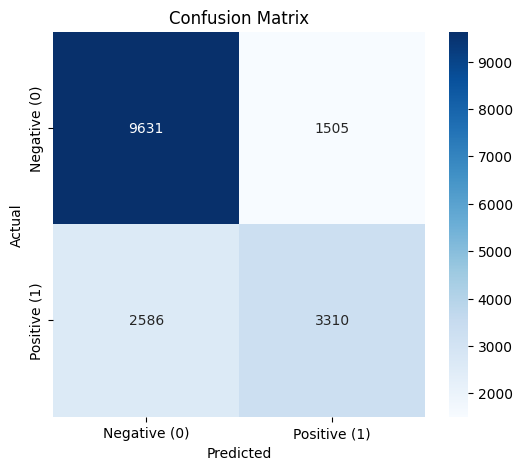

In [ ]:
cm = confusion_matrix(y_sel, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_prob_lr = model_lr.predict_proba(X_sel)[:, 1]
fpr_lr, tpr_lr, thresholds = roc_curve(y_sel, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

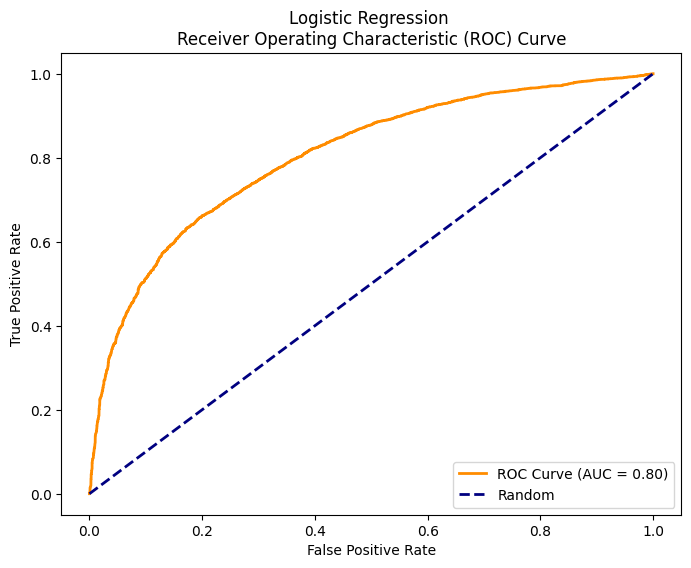

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression \nReceiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

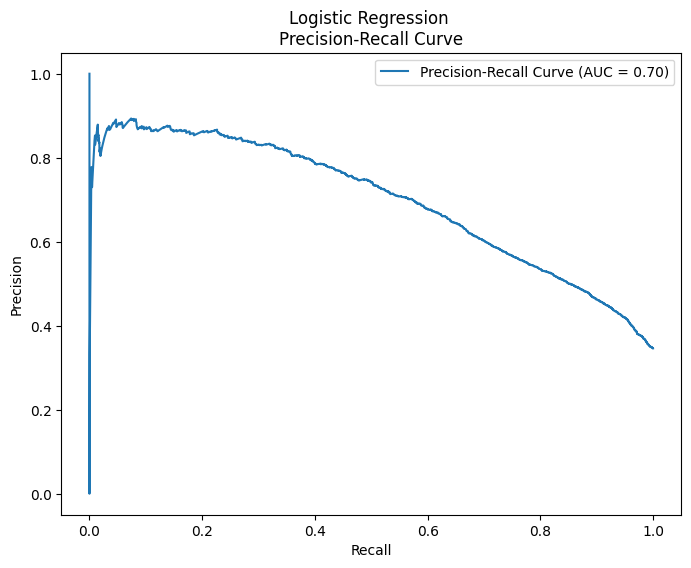

In [ ]:
pr_lr, recall_lr, thresholds_lr = precision_recall_curve(y_sel, y_prob_lr)
pr_auc_lr = auc(recall_lr, pr_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, pr_lr, label=f'Precision-Recall Curve (AUC = {pr_auc_lr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression \nPrecision-Recall Curve')
plt.legend()
plt.show()

### Random Forest

In [ ]:
# creating an base RF classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=42)

In [ ]:
# Define the cross-validation strategy (10-fold)
cv_rf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get the results
cv_results_rf = cross_validate(clf, X_sel, y_sel, cv=cv_rf,
                               scoring=scoring, n_jobs=-1)

# Calculate mean values for each metric
mean_accuracy_rf = np.mean(cv_results_rf['test_accuracy'])
mean_precision_rf = np.mean(cv_results_rf['test_precision'])
mean_recall_rf = np.mean(cv_results_rf['test_recall'])
mean_f1_rf = np.mean(cv_results_rf['test_f1'])
mean_roc_auc_rf = np.mean(cv_results_rf['test_roc_auc'])
mean_avg_precision_rf = np.mean(cv_results_rf['test_average_precision'])

# Print the results
print(f"Mean Accuracy: {mean_accuracy_rf:.4f}")
print(f"Mean Precision: {mean_precision_rf:.4f}")
print(f"Mean Recall: {mean_recall_rf:.4f}")
print(f"Mean F1-Score: {mean_f1_rf:.4f}")
print(f"Mean AUROC: {mean_roc_auc_rf:.4f}")
print(f"Mean Precision-Recall AUC: {mean_avg_precision_rf:.4f}")

Mean Accuracy: 0.7754
Mean Precision: 0.6843
Mean Recall: 0.6526
Mean F1-Score: 0.6679
Mean AUROC: 0.7465
Mean Precision-Recall AUC: 0.5668


In [ ]:
y_pred_rf = cross_val_predict(clf, X_sel, y_sel, cv=cv_rf)

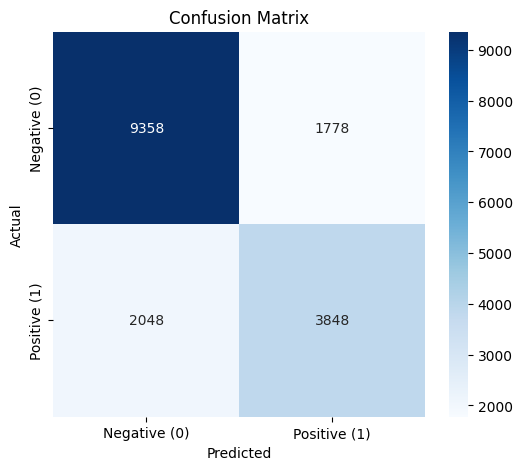

In [ ]:
cm = confusion_matrix(y_sel, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_prob_rf = clf.predict_proba(X_test_sel)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_sel, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print('AUROC:',round(roc_auc_rf, 2))

pr_rf, recall_rf, thresholds_lr = precision_recall_curve(y_test_sel, y_prob_rf)
pr_auc_rf = auc(recall_rf, pr_rf)
print('PR-AUC:',round(pr_auc_rf, 2))

AUROC: 0.8
PR-AUC: 0.77


In [ ]:
# Feature importance (Gini Importance)
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': selected_feats,
                               'Gini Importance': importances})\
                               .sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

                                              Feature  Gini Importance
0                                            ckd_icds         0.103910
1                                            ihd_icds         0.053603
2                                             dm_icds         0.048501
5                                prncpal_dgns_cd_Z733         0.037196
35                                   age_group_80-max         0.035352
3   health_insurance_civilian_18_64_not_labor_forc...         0.032845
4   health_insurance_civilian_18_64_not_labor_forc...         0.032343
6   health_insurance_civilian_18_64_employed_priva...         0.030655
7   health_insurance_civilian_18_64_unemployed_pri...         0.026895
13                     class_of_worker_government_pct         0.024097
8   health_insurance_civilian_18_64_employed_publi...         0.023867
26                            commute_drove_alone_pct         0.023256
12                         commute_worked_at_home_pct         0.023100
23    

In [ ]:
top_feat_names = list(feature_imp_df['Feature'][:10])
top_feat_imprt = list(feature_imp_df['Gini Importance'][:10])

In [ ]:
labels = [ '\n'.join(wrap(name, 20)) for name in top_feat_names]

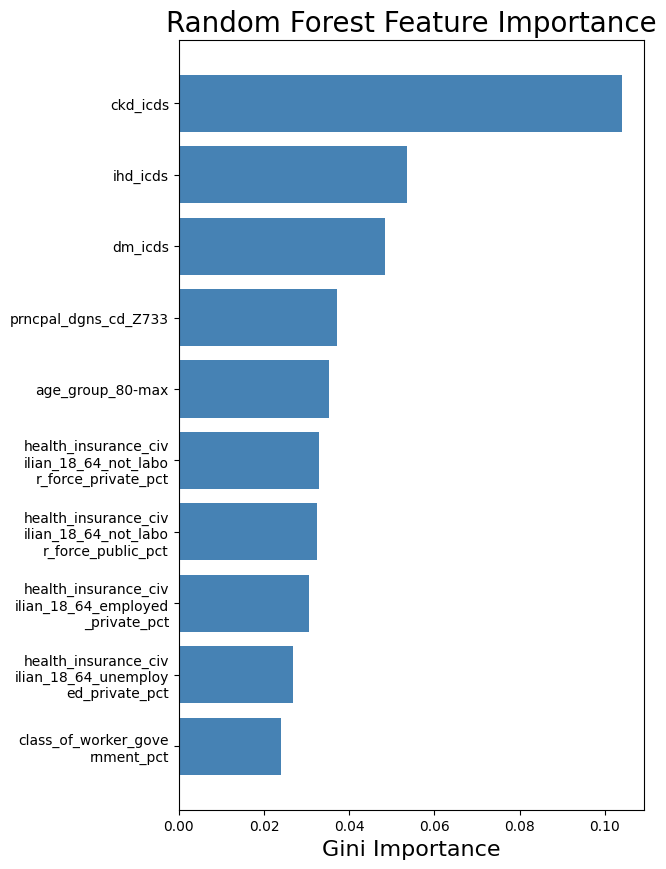

In [ ]:
plt.figure(figsize=(6, 10))
plt.barh(labels, top_feat_imprt, color='steelblue')
plt.xlabel('Gini Importance', fontsize=16)
plt.title('Random Forest Feature Importance', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()

### Tuned Random Forest

In [ ]:
if grid_search_params == 1:
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 15, 20, 25],
        'min_samples_split': np.linspace(0.1, 1, 10),
        'criterion': ['log_loss', 'entropy', 'gini'],
        'bootstrap': [True, False]
    }
    grid_search = GridSearchCV(RandomForestClassifier(),
                              param_grid=param_grid, cv=5, scoring='f1')
    print(grid_search.best_estimator_)
else:
  rf_gs = RandomForestClassifier()

In [ ]:
# fit model
if grid_search_params == 1:
    rf_gs = RandomForestClassifier(bootstrap=False,max_depth=20,
                                  min_samples_split=0.1,
                                  n_estimators=50, random_state=42)
    rf_gs.fit(X_tr, y_tr)

In [ ]:
if grid_search_params == 1:
    # Define the cross-validation strategy (10-fold)
    cv_rf_gs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Perform cross-validation and get the results
    cv_results_rf_gs = cross_validate(rf_gs, X_sel, y_sel, cv=cv_rf_gs,
                                  scoring=scoring, n_jobs=-1)

    # Calculate mean values for each metric
    mean_accuracy_rf_gs = np.mean(cv_results_rf_gs['test_accuracy'])
    mean_precision_rf_gs = np.mean(cv_results_rf_gs['test_precision'])
    mean_recall_rf_gs = np.mean(cv_results_rf_gs['test_recall'])
    mean_f1_rf_gs = np.mean(cv_results_rf_gs['test_f1'])
    mean_roc_auc_rf_gs = np.mean(cv_results_rf_gs['test_roc_auc'])
    mean_avg_precision_rf_gs = np.mean(cv_results_rf_gs['test_average_precision'])

    # Print the results
    print(f"Mean Accuracy: {mean_accuracy_rf_gs:.4f}")
    print(f"Mean Precision: {mean_precision_rf_gs:.4f}")
    print(f"Mean Recall: {mean_recall_rf_gs:.4f}")
    print(f"Mean F1-Score: {mean_f1_rf_gs:.4f}")
    print(f"Mean AUROC: {mean_roc_auc_rf_gs:.4f}")
    print(f"Mean Precision-Recall AUC: {mean_avg_precision_rf_gs:.4f}")

Mean Accuracy: 0.7767
Mean Precision: 0.7496
Mean Recall: 0.5331
Mean F1-Score: 0.6230
Mean AUROC: 0.7194
Mean Precision-Recall AUC: 0.5614


In [ ]:
if grid_search_params == 1:
    y_pred_rf_gs = cross_val_predict(rf_gs, X_sel, y_sel, cv=cv_rf_gs)

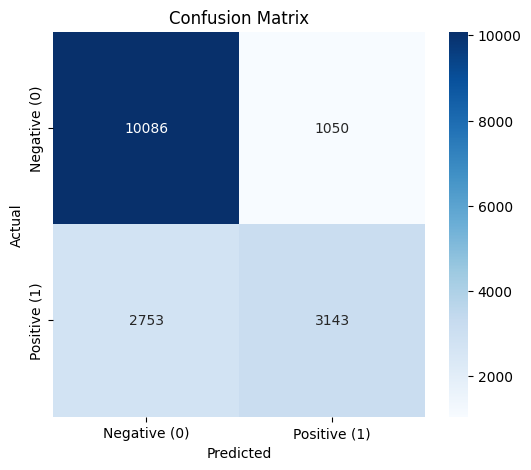

In [ ]:
if grid_search_params == 1:
    cm = confusion_matrix(y_sel, y_pred_rf_gs)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
if grid_search_params == 1:
    y_prob_rf_gs = rf_gs.predict_proba(X_test_sel)[:, 1]
    fpr_rf_gs, tpr_rf_gs, thresholds = roc_curve(y_test_sel, y_prob_rf_gs)
    roc_auc_rf_gs = auc(fpr_rf_gs, tpr_rf_gs)
    print('AUROC:',round(roc_auc_rf_gs, 2))

    pr_rf_gs,recall_rf_gs,thresholds_rf_gs = precision_recall_curve(y_test_sel,
                                                                  y_prob_rf_gs)
    pr_auc_rf_gs = auc(recall_rf_gs, pr_rf_gs)
    print('PR-AUC:',round(pr_auc_rf_gs, 2))

AUROC: 0.82
PR-AUC: 0.75


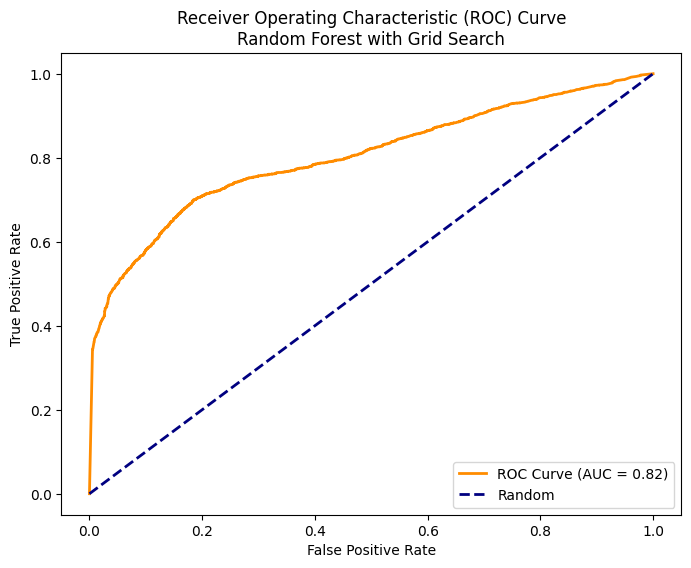

In [ ]:
if grid_search_params == 1:
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
            label=f'ROC Curve (AUC = {roc_auc_rf_gs:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve' +\
              '\nRandom Forest with Grid Search')
    plt.legend(loc="lower right")
    plt.show()

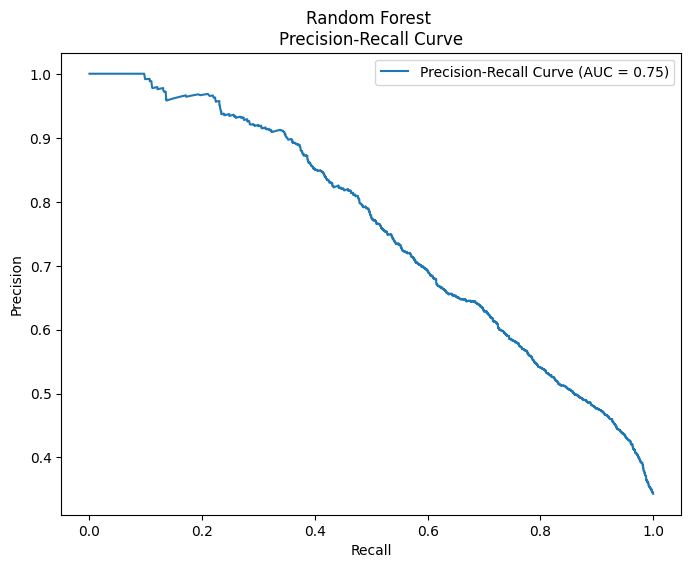

In [ ]:
if grid_search_params == 1:
    plt.figure(figsize=(8, 6))
    plt.plot(recall_rf_gs, pr_rf_gs,\
            label=f'Precision-Recall Curve (AUC = {pr_auc_rf_gs:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Random Forest \nPrecision-Recall Curve')
    plt.legend()
    plt.show()

In [ ]:
if grid_search_params == 1:
    # Feature importance (Gini Importance) - tuned RF
    importances = rf_gs.feature_importances_
    feature_imp_df_gs = pd.DataFrame({'Feature': selected_feats,
                                  'Gini Importance': importances})\
                                  .sort_values('Gini Importance', ascending=False)
    print(feature_imp_df_gs)

                                              Feature  Gini Importance
0                                            ckd_icds         0.266159
2                                             dm_icds         0.152616
1                                            ihd_icds         0.128939
35                                   age_group_80-max         0.089831
20                                           hlp_icds         0.066373
5                                prncpal_dgns_cd_Z733         0.056160
4   health_insurance_civilian_18_64_not_labor_forc...         0.042832
3   health_insurance_civilian_18_64_not_labor_forc...         0.031976
6   health_insurance_civilian_18_64_employed_priva...         0.031601
36                                     age_group_0-39         0.025616
7   health_insurance_civilian_18_64_unemployed_pri...         0.012861
8   health_insurance_civilian_18_64_employed_publi...         0.008813
29                   employment_unemployment_rate_pct         0.008333
14  he

In [ ]:
if grid_search_params == 1:
    top_feat_names_gs = list(feature_imp_df_gs['Feature'][:10])
    top_feat_imprt_gs = list(feature_imp_df_gs['Gini Importance'][:10])
    # wrap labels
    labels = [ '\n'.join(wrap(name, 20)) for name in top_feat_names_gs]

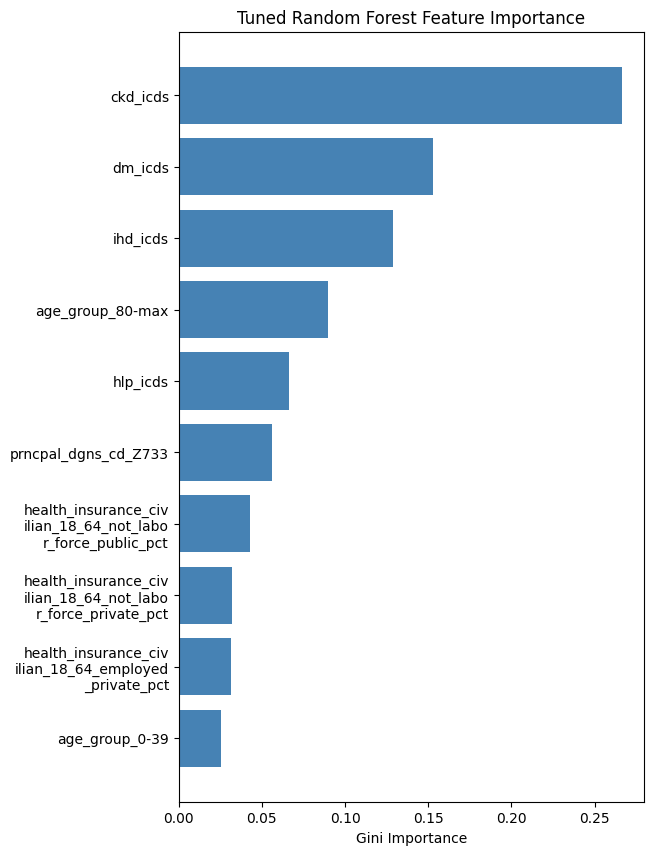

In [ ]:
if grid_search_params == 1:
    plt.figure(figsize=(6,10))
    plt.barh(labels, top_feat_imprt_gs, color='steelblue')
    plt.xlabel('Gini Importance')
    plt.title('Tuned Random Forest Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis
    plt.show()

### Neural Network

In [ ]:
# split data into train, test, and validation data
# creates a train/val/test set of 64/16/20

X_tr, X_val_sel, y_tr, y_val_sel = \
                  train_test_split(X_tr, y_tr, test_size=0.2, random_state=1)

# convert data to tensors
X_ten = torch.tensor(list(X_sel.values), dtype=torch.float32)
y_ten = torch.tensor(list(y_sel.values), dtype=torch.float32).reshape(-1, 1)

# convert data to tensors
X_ten_train = torch.tensor(list(X_tr.values), dtype=torch.float32)
y_ten_train = torch.tensor(list(y_tr.values), dtype=torch.float32).reshape(-1, 1)

X_ten_val = torch.tensor(list(X_val_sel.values), dtype=torch.float32)
y_ten_val = torch.tensor(list(y_val_sel.values), dtype=torch.float32).reshape(-1, 1)

X_ten_test = torch.tensor(list(X_test_sel.values), dtype=torch.float32)
y_ten_test = torch.tensor(list(y_test_sel.values), dtype=torch.float32).reshape(-1, 1)

<ipython-input-61-8551889ae0ad>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_ten = torch.tensor(list(X_sel.values), dtype=torch.float32)


In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(X_ten_train, y_ten_train)
val_dataset = TensorDataset(X_ten_val, y_ten_val)
test_dataset = TensorDataset(X_ten_test, y_ten_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
# base nn
class ReadmissionClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        # Define layers
        self.hidden1 = nn.Linear(input_size, 12)
        self.act1 = nn.Sigmoid()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.dropout(x)
        x = self.act_output(self.output(x))
        return x

In [ ]:
# deep nn
class DeepNN(nn.Module):
    def __init__(self, input_size):
        super(DeepNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.hidden3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.hidden4 = nn.Linear(32, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.25)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.hidden1(x)))
        x = F.relu(self.bn2(self.hidden2(x)))
        x = F.tanh(self.bn3(self.hidden3(x)))
        x = F.tanh(self.bn4(self.hidden4(x)))
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# input_size: all data
input_size = X_sel.shape[1]

# declare model by uncommenting one model
model = ReadmissionClassifier(input_size)
# model = DeepNN(input_size)

In [ ]:
# Initial loss funciton, optimizer, and learning rate
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# define early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)

In [ ]:
# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 100
batch_size = 100

# Store metrics for the test set for each fold
test_precisions = []
test_recalls = []
test_f1_scores = []
test_auroc = []
test_pr_auc = []
fold_auroc = []
fold_pr_auc = []

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_ten, y_ten)):
    print(f"Training for fold {fold+1}...")

    # Create data subsets for this fold
    train_subset = Subset(torch.utils.data.TensorDataset(X_ten, y_ten), train_idx)
    val_subset = Subset(torch.utils.data.TensorDataset(X_ten, y_ten), val_idx)

    # DataLoaders for this fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the model for this fold
    model = ReadmissionClassifier(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

    # Early stopping instance
    early_stopping = EarlyStopping(patience=5, delta=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            predicted = (output >= 0.5).float()  # Convert output to binary (0 or 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation step
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = loss_fn(output, target)
                val_loss += loss.item() * data.size(0)
                predicted = (output >= 0.5).float()
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)
                val_preds.extend(output.cpu().numpy())  # Store predictions
                val_targets.extend(target.cpu().numpy())  # Store true labels

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        # Print losses and accuracy for the current epoch
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
        #       f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping logic
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

Training for fold 1...
Early stopping
Training for fold 2...
Early stopping
Training for fold 3...
Early stopping
Training for fold 4...
Early stopping
Training for fold 5...
Early stopping
Training for fold 6...
Early stopping
Training for fold 7...
Early stopping
Training for fold 8...
Early stopping
Training for fold 9...
Early stopping
Training for fold 10...
Early stopping


In [ ]:
# Load the best model from early stopping
early_stopping.load_best_model(model)

# Test set evaluation after training each fold
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_preds.extend(output.cpu().numpy())  # Store predictions
        test_targets.extend(target.cpu().numpy())  # Store true labels

# Convert lists to numpy arrays
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Calculate and store metrics for the test set
precision = precision_score(test_targets, (test_preds >= 0.5).astype(int))
recall = recall_score(test_targets, (test_preds >= 0.5).astype(int))
f1 = f1_score(test_targets, (test_preds >= 0.5).astype(int))
auroc = roc_auc_score(test_targets, test_preds)
pr_auc = average_precision_score(test_targets, test_preds)

test_precisions.append(precision)
test_recalls.append(recall)
test_f1_scores.append(f1)
test_auroc.append(auroc)
test_pr_auc.append(pr_auc)

print(f"Fold {fold+1} - Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, "
      f"Test F1: {f1:.4f}, Test AUROC: {auroc:.4f}, Test PR AUC: {pr_auc:.4f}\n")

# Print the mean and std of all metrics across folds for the test set
mean_precision_nn = np.mean(test_precisions)
mean_recall_nn = np.mean(test_recalls)
mean_f1_nn = np.mean(test_f1_scores)
mean_roc_auc_nn = np.mean(test_auroc)
mean_avg_precision_nn = np.mean(test_pr_auc)

print(f"Mean Test Precision: {mean_precision_nn:.4f}")
print(f"Mean Test Recall: {mean_recall_nn:.4f}")
print(f"Mean Test F1 Score: {mean_f1_nn:.4f}")
print(f"Mean Test AUROC: {mean_roc_auc_nn:.4f}")
print(f"Mean Test Precision-Recall AUC: {mean_avg_precision_nn:.4f}")



Fold 10 - Test Precision: 0.7410, Test Recall: 0.5284, Test F1: 0.6169, Test AUROC: 0.8146, Test PR AUC: 0.7336

Mean Test Precision: 0.7410
Mean Test Recall: 0.5284
Mean Test F1 Score: 0.6169
Mean Test AUROC: 0.8146
Mean Test Precision-Recall AUC: 0.7336


In [ ]:
# Final evaluation on the test set (after cross-validation)
# Load the final model (best from all folds, or use an ensemble approach)
model.eval()
correct_test = 0
total_test = 0
final_test_preds = []
final_test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs >= 0.5).float()
        total_test += target.size(0)
        correct_test += (predicted == target).sum().item()
        final_test_preds.extend(outputs.cpu().numpy())  # Store predictions
        final_test_targets.extend(target.cpu().numpy())  # Store true labels

final_acc_nn = round(100 * correct_test / total_test)
print(f'Accuracy of the model on the final test set: {final_acc_nn:.2f}%')

Accuracy of the model on the final test set: 77.00%


In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds_roc = roc_curve(test_targets, test_preds)
roc_auc_nn = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc_nn:.2f}')

ROC AUC: 0.81


In [ ]:
# Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(test_targets,
                                                          test_preds)
pr_auc_nn = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc_nn:.2f}')

Precision-Recall AUC: 0.73


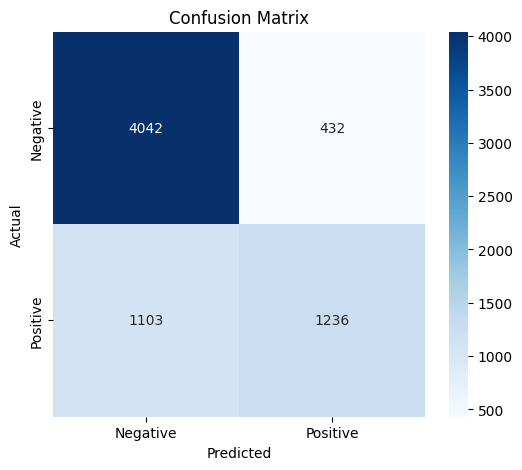

In [ ]:
test_preds_binary = (test_preds >= 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(test_targets, test_preds_binary)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Model Comparsion

In [ ]:
roc_auc = [mean_roc_auc_lr, mean_roc_auc_rf, mean_roc_auc_nn]
pr_auc = [mean_avg_precision_lr, mean_avg_precision_rf, mean_avg_precision_nn]
f1 = [mean_f1_lr, mean_f1_rf, mean_f1_nn]
model_labels = ['Logistic \nRegression', 'Random \nForest',
                'Deep Neural \nNetwork']
if grid_search_params == 1:
    roc_auc.insert(2, mean_roc_auc_rf_gs)
    pr_auc.insert(2, mean_avg_precision_rf_gs)
    f1.insert(2, mean_f1_rf_gs)
    model_labels.insert(2,'Random Forest \n(Grid Search)')

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

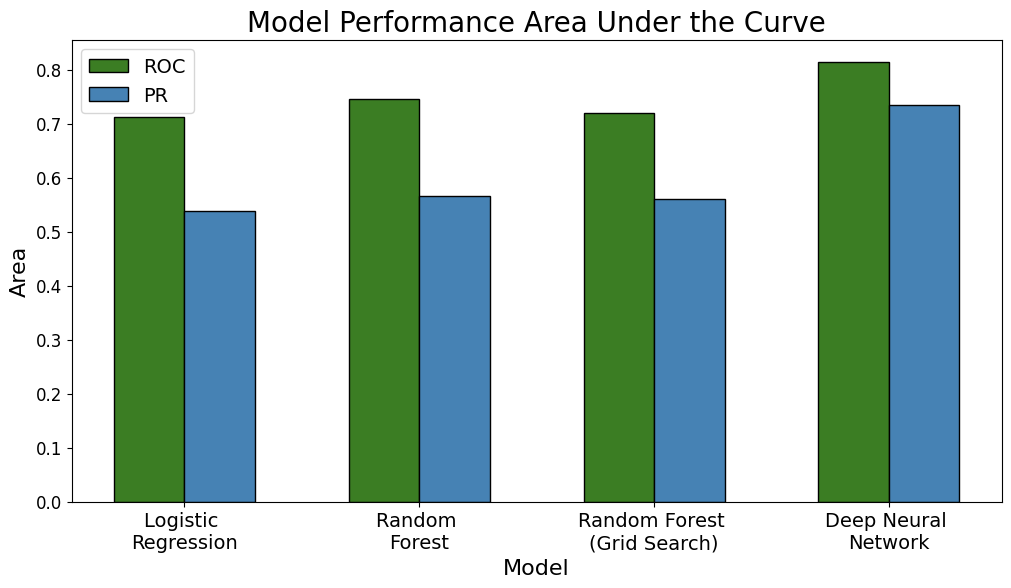

In [ ]:
# set the correct number of groupings of bars in the bar chart
n = 3 if grid_search_params == 0 else 4
r = np.arange(n)
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(r, roc_auc, color = '#3B7D23',
        width = width, edgecolor = 'black',
        label='ROC')
plt.bar(r + width, pr_auc, color = 'steelblue',
        width = width, edgecolor = 'black',
        label='PR')

plt.xlabel("Model")
plt.ylabel("Area")
plt.title("Model Performance Area Under the Curve")

plt.xticks(r + width/2,model_labels)
plt.legend()

plt.show()

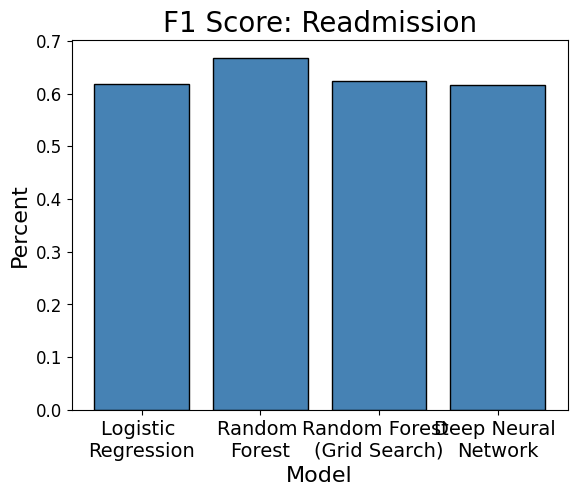

In [ ]:
# plot model accuracy comparision
plt.bar(model_labels,f1, color='steelblue',edgecolor = 'black')
plt.title('F1 Score: Readmission')
plt.xlabel('Model')
plt.ylabel('Percent')
plt.show()

## Making Predictions
Model: tuned RF

In [ ]:
if make_predictions == 1:
    # get predictions for full data
    all_preds = pd.DataFrame(rf_gs.predict(X_sel))

    # grab x set of selected features that includes dashboard reqs
    X_sel_dashboard = df_to_table.iloc[:, :-1]
    X_sel_dashboard = X_sel_dashboard.reset_index(drop=True)

    # reset index of x set of selected features
    X_sel = X_sel.reset_index(drop=True)
    Y_sel = pd.DataFrame(y_sel)
    Y_sel = Y_sel.reset_index(drop=True)

    # Merge dataframes on the index
    df_export = X_sel_dashboard.merge(Y_sel, left_index=True, right_index=True,
                                      how='inner')
    df_export = df_export.merge(all_preds, left_index=True, right_index=True,
                                how='inner')
    # rename prediction column
    df_export.rename(columns={0:'predicted'}, inplace=True)

    # rename label variable per dashboard specification
    df_export.rename(columns={'readmit_30':'actual'}, inplace=True)

In [ ]:
if save_to_csv == 1:
    # Save DataFrame to CSV
    df_export.to_csv('rq2_predictions.csv', index=False)

    # Download the file
    files.download('rq2_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Export Data and Model to Bucket

In [ ]:
if data_w_preds_in_bucket == 1:
    # GCS Path
    project_id = "spatial-earth-449020-m3"
    bucket_name = "capstone-group-data"

    model_path  = "final_models/readmissions_rf.pkl"
    feat_path   =  "final_models/readmissions_feat_order.json"

    client = storage.Client(project=project_id)
    bucket = client.bucket(bucket_name)

    # Derive feature order
    feature_order = X_sel_dashboard.columns.tolist()

    # Serialize model into memory
    model_bytes = pickle.dumps(rf_gs)
    feature_json = json.dumps(feature_order)

    # Upload model
    blob_model = bucket.blob(model_path)
    blob_model.upload_from_string(
        model_bytes,
        content_type="application/octet-stream"
    )

    # Upload Feature Order
    blob_feat = bucket.blob(feat_path)
    blob_feat.upload_from_string(
        feature_json,
        content_type="application/json"
    )

    # Convert any dates to integers
    df_export['claim_end_year'] = df_export['claim_end_year'].astype(int)

    # Force very small values to 0 or 1
    for col in df_export.select_dtypes(include=[float]).columns:
      unique_vals = df_export[col].dropna().unique()
      if unique_vals.min() >= -1e-6 and unique_vals.max() <= 1+1e-6:
          df_export[col] = np.where(
              df_export[col] >= 0.5, 1, 0
          ).astype(int)

    client = bigquery.Client(project="spatial-earth-449020-m3")
    table_id = (
        "spatial-earth-449020-m3."
        "capstone_finalized_model_datasets_w_predictions."
        "beneficiary_inpatient_readmission_w_predictions_rf"
    )

    # Configure the load job: overwrite the existing table, autodetect schema
    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        autodetect=True
    )

    # Load the DataFrame into BigQuery
    load_job = client.load_table_from_dataframe(
        df_export,
        table_id,
        job_config=job_config
    )

    # 6) Wait for it to complete
    load_job.result()

    print(
        f"Data successfully loaded into: {table_id}\n"
        "All existing data was replaced with new rows."
    )